In [1]:
import numpy as np

import torch
from torch import nn
from torch import optim

import time
import tqdm

import tkinter
import pickle

from IPython.display import clear_output

import sys

sys.path.append('..')

import pyro
from pyro.infer import HMC, MCMC, NUTS
from samplers import mala, i_sir, ex2_mcmc
import ot
import jax
import gc

from cifar10_experiments.models import Generator, Discriminator

from sampling_utils.adaptive_mc import CISIR, Ex2MCMC, FlowMCMC
from sampling_utils.adaptive_sir_loss import MixKLLoss
from sampling_utils.distributions import (
    Banana,
    CauchyMixture,
    Distribution,
    Funnel,
    HalfBanana,
    IndependentNormal,
)
from sampling_utils.ebm_sampling import MALA
from sampling_utils.flows import RNVP
from sampling_utils.metrics import ESS, acl_spectrum
from sampling_utils.total_variation import (
    average_total_variation,
)

2023-05-29 19:44:13.076268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#!pip install pyro-ppl easydict pot flax mlpaper
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def sample_nuts(target, proposal, device = 'cpu', num_samples=1000, burn_in=1000, batch_size=1, rand_seed = 42):
    def true_target_energy(z):
        return -target(z)

    def energy(z):
        z = z["points"]
        return true_target_energy(z).sum()
    start_time = time.time()
    # kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
    kernel_true = NUTS(potential_fn=energy, full_mass=False)
    #kernel_true = HMC(potential_fn=energy, full_mass=False)
    pyro.set_rng_seed(rand_seed)
    init_samples = proposal.sample((batch_size,)).to(device)
    print(init_samples.shape) 
    #init_samples = torch.zeros_like(init_samples)
    dim = init_samples.shape[-1]
    init_params = {"points": init_samples}
    mcmc_true = MCMC(
        kernel=kernel_true,
        num_samples=num_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()
    q_true = mcmc_true.get_samples(group_by_chain=True)["points"].cpu()
    samples_true = np.array(q_true.view(-1, batch_size, dim))
    end_time = time.time()
    return end_time-start_time, samples_true

In [5]:
def plot_learned_density(
    flow,
    proposal,
    fig=None,
    device="cpu",
    xlim=[-1, 1],
    ylim=[-1, 1],
    rest=0.0,
):
    if fig is None:
        fig = plt.figure()
    n_pts = 200
    z = proposal.sample((n_pts**2,))
    x = np.linspace(*xlim, n_pts)
    y = np.linspace(*ylim, n_pts)
    xx, yy = np.meshgrid(x, y)
    zz = np.stack([xx, yy], -1)
    z[:, :2] = torch.FloatTensor(zz).view(-1, 2).to(device)
    z[:, 2:] = torch.FloatTensor([rest] * n_pts**2)[:, None]

    inv, minus_log_jac = flow.inverse(z)
    minus_log_jac = minus_log_jac.reshape(n_pts, n_pts)
    inv = inv.reshape(n_pts, n_pts, -1)
    vals = (proposal(inv) + minus_log_jac).exp().detach()

    im = plt.contourf(xx, yy, vals.reshape(n_pts, n_pts), cmap="GnBu")
    fig.colorbar(im)
    return fig

def compute_metrics(
    xs_true,
    xs_pred,
    name=None,
    n_samples=1000,
    scale=1.0,
    trunc_chain_len=None,
    ess_rar=1,
):
    metrics = dict()
    key = jax.random.PRNGKey(0)
    n_steps = 25
    # n_samples = 100

    ess = ESS(
        acl_spectrum(
            xs_pred[::ess_rar] - xs_pred[::ess_rar].mean(0)[None, ...],
        ),
    ).mean()
    metrics["ess"] = ess

    xs_pred = xs_pred[-trunc_chain_len:]
    print(xs_true.shape)
    print(xs_pred.shape)

    tracker = average_total_variation(
        key,
        xs_true,
        xs_pred,
        n_steps=n_steps,
        n_samples=n_samples,
    )

    metrics["tv_mean"] = tracker.mean()
    metrics["tv_conf_sigma"] = tracker.std_of_mean()

    mean = tracker.mean()
    std = tracker.std()

    metrics["emd"] = 0
    #Cost_matr_isir = ot.dist(x1 = isir_res[j][i], x2=gt_samples[i], metric='sqeuclidean', p=2, w=None)
    for b in range(xs_pred.shape[1]):
        M = ot.dist(xs_true / scale, xs_pred[:, b,:] / scale)
        emd = ot.lp.emd2([], [], M, numItermax = 1e6)
        metrics["emd"] += emd / xs_pred.shape[1]

    if name is not None:
        print(f"===={name}====")
    print(
        f"TV distance. Mean: {mean:.3f}, Std: {std:.3f}. \nESS: {ess:.3f} \nEMD: {emd:.3f}",
    )

    return metrics

In [6]:
def plot_metrics(metrics, ndims, savepath=None, scale=1.0, colors=None):
    axs_names = ["Sliced TV", "ESS", "EMD ratio"]  # (on scaled data)']
    ncols = len(axs_names)

    figs = []
    axs = []
    for _ in range(ncols):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
        figs.append(fig)
        axs.append(ax)

    mala_emd = metrics['MALA']['emd']
    
    for (name, res), color in zip(metrics.items(), colors):
        for k, v in res.items():
            res[k] = np.array(v)

        arr = res["tv_mean"]
        axs[0].plot(ndims, arr, label=name, marker="o", color=color)

        axs[0].fill_between(
            ndims,
            res["tv_mean"] - 1.96 * res["tv_conf_sigma"],
            res["tv_mean"] + 1.96 * res["tv_conf_sigma"],
            alpha=0.2,
        )

        arr = res["ess"]
        axs[1].plot(ndims, arr, label=name, marker="o", color=color)

        if name != 'MALA':
            arr = mala_emd / res["emd"]
            axs[2].plot(ndims, arr, label=name, marker="o", color=color)
        #axs[2].set_yscale("log")

    for ax, fig, name in zip(axs, figs, axs_names):
        ax.grid()
        ax.set_title(name.split(' ')[0])
        ax.set_xlabel("dim")
        if name == "EMD ratio":
            ax.legend()

        fig.tight_layout()

        if savepath is not None:
            fig.savefig(Path(savepath, f"{name}.pdf"))

In [7]:
n_steps = 1
dist = "banana"
dim = 80
scale_proposal = 1.
scale_isir = 5.
dist_class = "Banana"
dist_params = {
    "b": 0.02,
    "sigma":5.0,
}
sigma = 5.0
b = 0.02

In [8]:
device = "cuda"
#method_metric_dict = defaultdict(lambda: defaultdict(list))

In [9]:
target = Banana(
                dim=dim,
                device=device,
                b = b,
                sigma = sigma,
                #b = b
                #**dist_params.dict,
)

loc_proposal = torch.zeros(dim).to(device)
scale_proposal = scale_proposal * torch.ones(dim).to(device)
scale_isir = scale_isir * torch.ones(dim).to(device)

proposal = IndependentNormal(
    dim=dim,
    loc=loc_proposal,
    scale=scale_proposal,
    device=device,
)

proposal_ex2 = IndependentNormal(
    dim=dim,
    loc=loc_proposal,
    scale=scale_isir,
    device=device,
)

In [10]:
proposal.sample((2,)).shape

torch.Size([2, 80])

In [11]:
u = np.ones((2, 100))

w = torch.tensor(u, requires_grad=True)

In [12]:
u.shape, w.shape

((2, 100), torch.Size([2, 100]))

In [13]:
target(u)

array([-44.608, -44.608])

In [14]:
w

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=torch.float64,
       requires_grad=True)

### Generate ground-truth samples

In [15]:
N_samples = 2*10**3
np.random.seed(42)
True_samples = np.random.randn(N_samples,dim)
for i in range(dim):
    if i % 2 == 0:
      True_samples[:,i] *= sigma
    else:
      True_samples[:,i] += b*True_samples[:,i-1]**2 - (sigma**2)*b

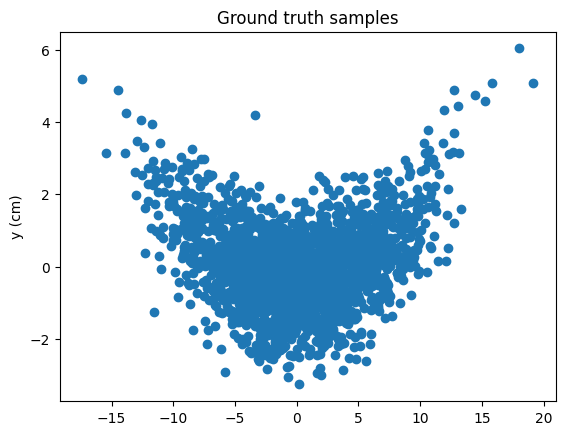

In [16]:
fig,ax=plt.subplots(1,1)
#cp = ax.contourf(X, Y, dens_vals)
#fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(True_samples[:,2],True_samples[:,3])
ax.set_title('Ground truth samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Sample with NUTS

In [17]:
#samples to compute ground-truth metrics
Nuts_samples_ground_truth = 2000
#Nuts_samples_comparison
trunc_chain_len = 1000
#nuts samples burn_in
nuts_burn_in = 500
#nuts batch size
nuts_batch = 1

### Generate ground-truth samples (with NUTS)

In [18]:
#samples_true = sample_nuts(
#                target,
#                proposal,
#                num_samples=Nuts_samples_ground_truth,#config.trunc_chain_len,
#                batch_size=nuts_batch, #config.batch_size
#)[:, 0, :]
#print(samples_true.shape)

In [19]:
rand_seed = 42
time_nuts, sample_nuts_ref = sample_nuts(
                target,
                proposal,
                device,
                num_samples=trunc_chain_len,
                batch_size=nuts_batch,
                burn_in=nuts_burn_in,
                rand_seed = rand_seed
)
print(sample_nuts_ref.shape)

torch.Size([1, 80])


Sample: 100%|█| 1500/1500 [00:32, 45.79it/s, step size=2.56e-01, acc. prob=0.894

(1000, 1, 80)


In [20]:
sample_nuts_ref.shape

(1000, 1, 80)

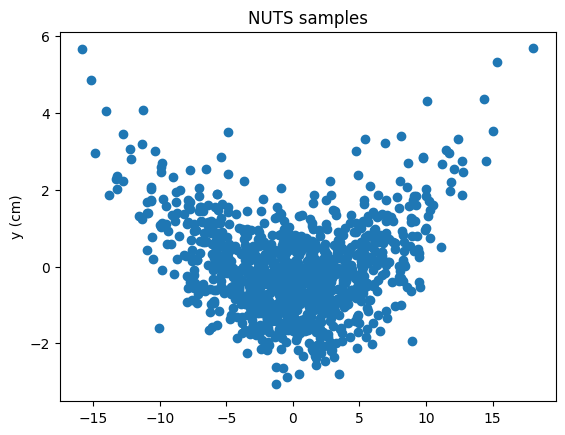

In [21]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_nuts_ref[:,0,0],sample_nuts_ref[:,0,1])
ax.set_title('NUTS samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [22]:
metrics = compute_metrics(
                    True_samples,
                    sample_nuts_ref,
                    name="NUTS",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(2000, 80)
(1000, 1, 80)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.035, Std: 0.006. 
ESS: 0.411 
EMD: 1170.984


### Sample with Ex2MCMC

In [23]:
params = {
      "N": 200,
      "grad_step": 0.1,
      "adapt_stepsize": True, #True
      "corr_coef": 0.0,
      "bernoulli_prob_corr": 0.0, #0.75
      "mala_steps": 3
}
        
n_steps_ex2 = 5000
batch_size = 1

In [24]:
mcmc = Ex2MCMC(**params, dim=dim)
pyro.set_rng_seed(43)
start = proposal_ex2.sample((batch_size,)).to(device)
print(start)
# s = time.time()
out = mcmc(start, target, proposal_ex2, n_steps = n_steps_ex2)
print(out[1])
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out
sample = np.array(
    [_.detach().numpy() for _ in sample],
).reshape(-1, batch_size, dim)
sample_ex2_final = sample[:,0,:]
print(sample_ex2_final.shape)

tensor([[  9.9913,   9.9050,   7.2289,   9.9065,   5.9921,   7.5368,   6.1781,
         -10.9405,  -0.6787,   3.3785, -12.3315,  -1.9842,   1.5407,   0.2900,
           1.1881,   1.2645,   8.2558,  -6.7373,  -4.7210,  -1.9920,  -1.2510,
           3.2862,  -7.0136,   2.8805,  -6.3104,  -5.0820,   2.9485,   5.6374,
          -4.9450,  -9.5301,   4.8711,   3.3871,  -3.0672,   5.4622,   0.1409,
           3.1283,  -2.9928,  -7.0726,  -8.1188, -11.9510,  -1.1162,  -3.0334,
          -6.6033,  -4.4382,  -5.9257,  -2.7591,   3.8157,   5.6175,   3.5981,
          -7.4200,  -2.6217,   2.2143,   3.2860,  -4.3273,  -1.0528,   9.8987,
           4.7667,  -3.9605,   2.4402,  -1.7367,  -2.4408,  -3.5202,   6.6920,
           5.5682,  -1.5166,  -7.3930,  -0.7541,  -0.8745,  -4.1083,  -0.6844,
           3.8512,  -7.9397,  -8.8802,   6.4396,   6.2308,   7.8404,  -1.9925,
           3.9823,  -1.6386,   2.5123]], device='cuda:0')


100%|██████████████████████████████████████| 5000/5000 [00:39<00:00, 125.60it/s]

tensor([0.5008])
(5000, 80)


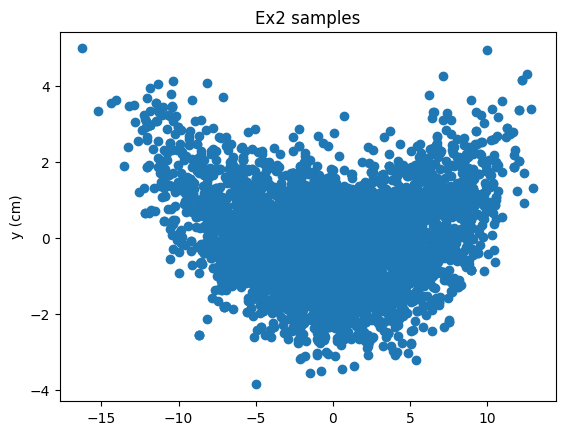

In [25]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1])
ax.set_title('Ex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Sample with Flex2MCMC (adaptive version)

In [26]:
params_flex = {
      "N": 200,
      "grad_step": 0.2,
      "adapt_stepsize": True,
      "corr_coef": 0.0,
      "bernoulli_prob_corr": 0.0,
      "mala_steps": 0,
    "flow": {
      "num_flows": 4, # number of normalizing layers 
      "lr": 1e-3, # learning rate 
      "batch_size": 100,
      "n_steps": 800,
    }
}
batch_size = 1
torch.cuda.empty_cache()

In [27]:
pyro.set_rng_seed(47)
mcmc = Ex2MCMC(**params_flex, dim=dim)
verbose = mcmc.verbose
mcmc.verbose = False
flow = RNVP(params_flex["flow"]["num_flows"], dim=dim, device = device)
flow_mcmc = FlowMCMC(
    target,
    proposal,
    device,
    flow,
    mcmc,
    batch_size=params_flex["flow"]["batch_size"],
    lr=params_flex["flow"]["lr"],
)
flow.train()
out_samples, nll = flow_mcmc.train(
    n_steps=params_flex["flow"]["n_steps"],
)
assert not torch.isnan(
    next(flow.parameters())[0, 0],
).item()
gc.collect()
torch.cuda.empty_cache()
flow.eval()
mcmc.flow = flow
mcmc.verbose = verbose

100%|█████████████████████████████████████████| 800/800 [00:17<00:00, 46.05it/s]


In [28]:
#sample from a normalizing flow
n_steps_flex2 = 2000
batch_size = 1
pyro.set_rng_seed(42)
start = proposal.sample((batch_size,))
mcmc.N = 200
mcmc.mala_steps = 0
mcmc.grad_step = 0.1
# s = time.time()
out = mcmc(start, target, proposal, n_steps = n_steps_flex2)
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out
sample = np.array(
    [_.detach().numpy() for _ in sample],
).reshape(-1, batch_size, dim)
sample_flex2_new = sample
#resample with 0 mala steps
torch.cuda.empty_cache()
mcmc.mala_steps = 5
out_new = mcmc(start, target, proposal, n_steps = n_steps_flex2)
print(out_new[1])
out_new = out_new[0]
out_new = np.array(
    [_.detach().numpy() for _ in out_new],
).reshape(-1, batch_size, dim)
sample_flex2_final = out_new
print(sample_flex2_final.shape)

100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 63.64it/s]

tensor([0.5018])
(2000, 1, 80)


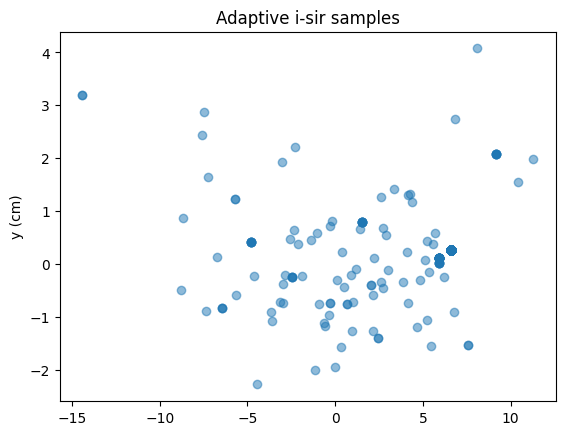

In [29]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_flex2_new[:,0,0],sample_flex2_new[:,0,1],alpha = 0.5)
ax.set_title('Adaptive i-sir samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
#ax.set_yscale('log')
plt.show()

In [30]:
trunc_chain_len = 1000
metrics = compute_metrics(
                    True_samples,
                    sample_flex2_new,
                    name="Adaptive i-sir",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(2000, 80)
(1000, 1, 80)


  0%|          | 0/25 [00:00<?, ?it/s]

====Adaptive i-sir====
TV distance. Mean: 0.886, Std: 0.024. 
ESS: 0.069 
EMD: 2352.994


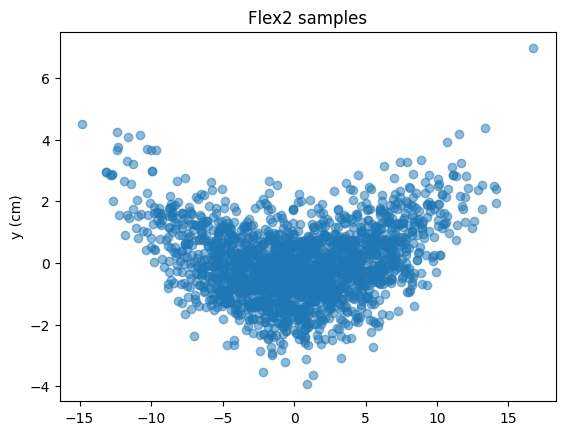

In [31]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],alpha = 0.5)
ax.set_title('Flex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
#ax.set_yscale('log')
plt.show()

In [32]:
metrics = compute_metrics(
                    True_samples,
                    sample_flex2_final,
                    name="Flex2",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(2000, 80)
(1000, 1, 80)


  0%|          | 0/25 [00:00<?, ?it/s]

====Flex2====
TV distance. Mean: 0.046, Std: 0.014. 
ESS: 0.305 
EMD: 1203.439


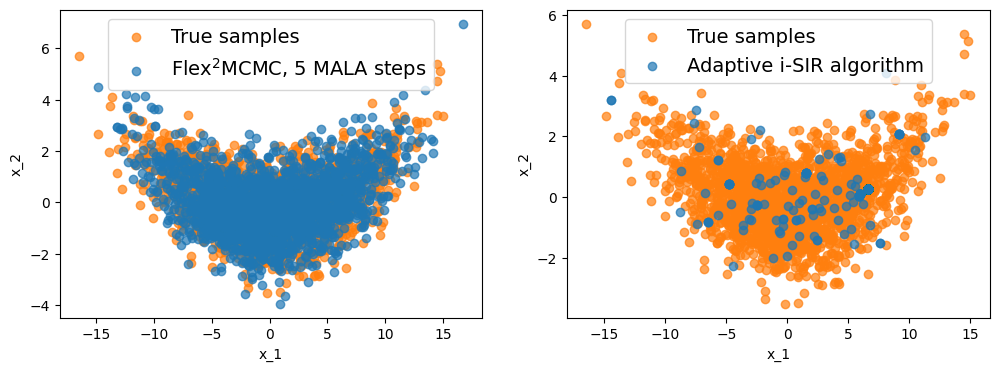

In [33]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
ax[0].scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4', alpha = 0.7, label = "Flex$^2$MCMC, 5 MALA steps")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
#ax[0].set_title('All samples')
ax[0].set_xlabel('x_1')
ax[0].set_ylabel('x_2')
ax[0].legend(fontsize=14)
#ax.set_yscale('log')
#plt.legend()
#plt.show()
#ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4',label = "Flex samples")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
ax[1].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
ax[1].scatter(sample_flex2_new[:,0,0],sample_flex2_new[:,0,1],c='#1f77b4', alpha = 0.7, label = "Adaptive i-SIR algorithm")
#ax[1].set_title('All samples')
ax[1].set_xlabel('x_1')
ax[1].set_ylabel('x_2')
#ax.set_yscale('log')
plt.legend(fontsize=14)
#plt.savefig(Path(
#        "./",
#        f"flow_funnel_samples_dim_{dim}_var_2_N_{mcmc.N}_mala_{mcmc.mala_steps}.pdf",
#        ), format="pdf", bbox_inches="tight") 
plt.savefig("banana_visualize_d_100.png",format="png", bbox_inches="tight")
plt.show()

NameError: name 'ans' is not defined

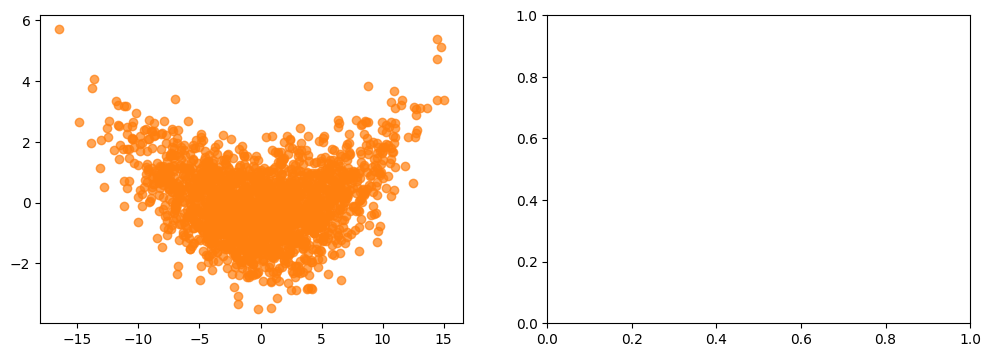

In [34]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
ax[0].scatter(ans[:,0],ans[:,1],c='#1f77b4', alpha = 0.7, label = "TT")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
#ax[0].set_title('All samples')
ax[0].set_xlabel('x_1')
ax[0].set_ylabel('x_2')
ax[0].legend(fontsize=14)
#ax.set_yscale('log')
#plt.legend()
#plt.show()
#ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4',label = "Flex samples")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
ax[1].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
ax[1].scatter(sample_nuts_ref[:,0,0],sample_nuts_ref[:,0,1],c='#1f77b4', alpha = 0.7, label = "NUTS")
#ax[1].set_title('All samples')
ax[1].set_xlabel('x_1')
ax[1].set_ylabel('x_2')
#ax.set_yscale('log')
plt.legend(fontsize=14)
#plt.savefig(Path(
#        "./",
#        f"flow_funnel_samples_dim_{dim}_var_2_N_{mcmc.N}_mala_{mcmc.mala_steps}.pdf",
#        ), format="pdf", bbox_inches="tight") 
plt.savefig("banana_visualize_d_100.png",format="png", bbox_inches="tight")
plt.show()

In [ ]:
sample_nuts_ref.shape

In [35]:
def Banana1(a, b):
    def density(z):
        # n = self.dim/2
        d = z.shape[1]
        even = np.arange(0, d, 2)
        odd = np.arange(1, d, 2)

        ll = (
                -0.5 * (z[..., odd] - b * z[..., even] ** 2 + (a**2)*b) ** 2
                - ((z[..., even]) ** 2) / (2 * a**2)
        )
        return np.exp(ll.sum(-1)/2)

    return density

In [36]:
def banana(a, b):
    def density(z):
        # n = self.dim/2
        d = z.shape[1]
        even = np.arange(0, d, 2)
        odd = np.arange(1, d, 2)

        ll = (
                -0.5 * (z[..., odd] - b * z[..., even] ** 2 + (a**2)*b) ** 2
                - ((z[..., even]) ** 2) / (2 * a**2)
        )
        return np.exp(ll.sum(-1))

    return density

def log_grad_banana(a, b):
    def density(z):
        # n = self.dim/2
        d = z.shape[1]
        ans = np.empty_like(z)
        even = np.arange(0, d, 2)
        odd = np.arange(1, d, 2)
        ans[..., even] = -z[..., even]/a**2 + (z[..., odd] - b * z[..., even]**2 + a**2 * b) * 2 * b * z[..., even]
        ans[..., odd] = -(z[..., odd] - b * z[..., even]**2 + a**2 * b)
        return ans

    return density

In [ ]:
def log_banana(a, b):
    def density(z):
        # n = self.dim/2
        d = z.shape[1]
        even = torch.arange(0, d, 2)
        odd = torch.arange(1, d, 2)

        ll = (
                -0.5 * (z[..., odd] - b * z[..., even] ** 2 + (a**2)*b) ** 2
                - ((z[..., even]) ** 2) / (2 * a**2)
        )
        return ll.sum(-1)

    return density

def log_grad_banana(a, b):
    def density(z):
        # n = self.dim/2
        d = z.shape[1]
        ans = torch.empty_like(z)
        even = torch.arange(0, d, 2)
        odd = torch.arange(1, d, 2)
        ans[..., even] = -z[..., even]/a**2 + (z[..., odd] - b * z[..., even]**2 + a**2 * b) * 2 * b * z[..., even]
        ans[..., odd] = -(z[..., odd] - b * z[..., even]**2 + a**2 * b)
        return ans

    return density

In [37]:
x = torch.randn(1, 10, requires_grad=True)

In [38]:
a = 5.0
b = 0.02
x.grad.data.zero_()
f = log_banana(a, b)
u = log_grad_banana(a, b)
v = f(x)
v.backward()

AttributeError: 'NoneType' object has no attribute 'data'

In [39]:
x.grad

In [40]:
u(x)

TypeError: 'numpy.ndarray' object is not callable

In [41]:
from scipy.optimize import approx_fprime

a = 5.0
b = 0.02
d=6
z = np.random.randn(d)
ap_gr = approx_fprime(z, log_banana(a, b))
gr = log_grad_bananaa(a, b)(z)

NameError: name 'log_banana' is not defined

In [42]:
ap_gr, gr

NameError: name 'ap_gr' is not defined

In [43]:
import tensors.sirt2 as sirt

In [44]:
n_steps = 1
dist = "Funnel"
d = 80
a = 5.0
b = 0.02
num_centers = 50
sigma = 0.2
target = sirt.Banana(a, b) # normal_density_general(np.zeros(d), Sigma) #
dots = [(-15., 15.)] * d
dots[0] = (-15., 15.)
steps = [100] *d

In [45]:
cross, grids = sirt.TT_cross_density(target, dots, steps, d, sirt.make_meshgrids_lin)
lists = cross.to_list(cross)
ans, pdfs = sirt.SIRT_sampling(cross.to_list(cross), np.random.uniform(size=(2000, d)),
                            grids)

None


/home/hdilab/miniconda3/lib/python3.10/site-packages/tt/multifuncrs2.py:179: RuntimeWarning: invalid value encountered in double_scalars
  dy = np.linalg.norm(newy - oldy) / np.linalg.norm(newy)


=multifuncrs= sweep 1{2}, max_dy: inf, erank: 5.93717
=multifuncrs= sweep 2{1}, max_dy: 7.886e-01, erank: 7.7039
=multifuncrs= sweep 2{2}, max_dy: 7.886e-01, erank: 9.17265
=multifuncrs= sweep 3{1}, max_dy: 5.584e-04, erank: 10.5795
=multifuncrs= sweep 3{2}, max_dy: 5.584e-04, erank: 11.0939
=multifuncrs= sweep 4{1}, max_dy: 9.037e-12, erank: 11.1074


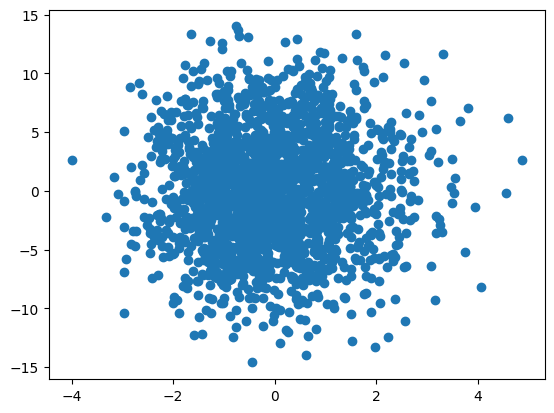

In [46]:
plt.scatter(ans[:,5],ans[:,6])

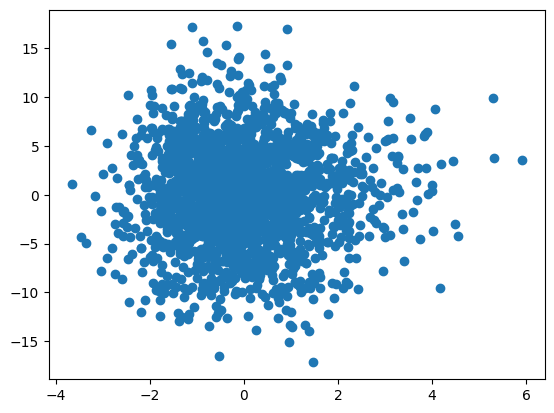

In [47]:
plt.scatter(True_samples[:,5],True_samples[:,6])

In [48]:
metrics = compute_metrics(
                    True_samples,
                    sample_nuts_ref,
                    name="NUTS",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(2000, 80)
(1000, 1, 80)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.035, Std: 0.006. 
ESS: 0.411 
EMD: 1170.984


In [51]:
ds = np.arange(10, 80, 10)
anses = []
a = 5.0
b = 0.02
for d in tqdm.notebook.tqdm(ds):
    target = sirt.Banana(a, b)
    dots = [(-15., 15.)] * d
    dots[0] = (-15., 15.)
    steps = [100] *d
    cross, grids = sirt.TT_cross_density(target, dots, steps, d, sirt.make_meshgrids_lin)
    lists = cross.to_list(cross)
    ans, pdfs = sirt.SIRT_sampling(cross.to_list(cross), np.random.uniform(size=(1000, d)),
                            grids)
    anses.append(ans)

  0%|          | 0/7 [00:00<?, ?it/s]

None
=multifuncrs= sweep 1{2}, max_dy: 1.473e+24, erank: 5.47723
=multifuncrs= sweep 2{1}, max_dy: 9.890e-01, erank: 7.20417
=multifuncrs= sweep 2{2}, max_dy: 9.890e-01, erank: 8.52056
=multifuncrs= sweep 3{1}, max_dy: 1.126e-05, erank: 9.80816
=multifuncrs= sweep 3{2}, max_dy: 1.126e-05, erank: 10.247
=multifuncrs= sweep 4{1}, max_dy: 8.876e-12, erank: 10.247
None
=multifuncrs= sweep 1{2}, max_dy: 1.763e+127, erank: 5.74456
=multifuncrs= sweep 2{1}, max_dy: 1.047e-01, erank: 7.59934
=multifuncrs= sweep 2{2}, max_dy: 1.047e-01, erank: 9.03604
=multifuncrs= sweep 3{1}, max_dy: 1.610e-06, erank: 10.2274
=multifuncrs= sweep 3{2}, max_dy: 1.610e-06, erank: 10.7471
=multifuncrs= sweep 4{1}, max_dy: 8.926e-12, erank: 10.7471
None
=multifuncrs= sweep 1{2}, max_dy: 1.271e+127, erank: 5.83095
=multifuncrs= sweep 2{1}, max_dy: 9.733e-01, erank: 7.59605
=multifuncrs= sweep 2{2}, max_dy: 9.733e-01, erank: 9.08479
=multifuncrs= sweep 3{1}, max_dy: 1.110e-04, erank: 10.3843
=multifuncrs= sweep 3{2},

In [52]:
nutses = []
sigma = 5.0
b = 0.02
for dim in tqdm.notebook.tqdm(ds):
    target = Banana(
                dim=dim,
                device=device,
                b = b,
                sigma = sigma,
                #b = b
                #**dist_params.dict,
    )

    loc_proposal = torch.zeros(dim).to(device)
    scale_proposal = 1.
    scale_proposal = scale_proposal * torch.ones(dim).to(device)
    
    proposal = IndependentNormal(
        dim=dim,
        loc=loc_proposal,
        scale=scale_proposal,
        device=device,
    )
    time_nuts, sample_nuts_ref = sample_nuts(
                target,
                proposal,
                device,
                num_samples=trunc_chain_len,
                batch_size=nuts_batch,
                burn_in=nuts_burn_in,
                rand_seed = rand_seed
    )
    nutses.append(sample_nuts_ref)

  0%|          | 0/7 [00:00<?, ?it/s]

torch.Size([1, 10])


Sample: 100%|█| 1500/1500 [00:22, 67.87it/s, step size=3.44e-01, acc. prob=0.933


torch.Size([1, 20])


Sample: 100%|█| 1500/1500 [00:27, 54.93it/s, step size=3.27e-01, acc. prob=0.915


torch.Size([1, 30])


Sample: 100%|█| 1500/1500 [00:29, 50.44it/s, step size=3.03e-01, acc. prob=0.908


torch.Size([1, 40])


Sample: 100%|█| 1500/1500 [00:31, 47.33it/s, step size=3.09e-01, acc. prob=0.890


torch.Size([1, 50])


Sample: 100%|█| 1500/1500 [00:32, 46.50it/s, step size=2.93e-01, acc. prob=0.891


torch.Size([1, 60])


Sample: 100%|█| 1500/1500 [00:33, 45.10it/s, step size=2.87e-01, acc. prob=0.883


torch.Size([1, 70])


Sample: 100%|█| 1500/1500 [00:33, 45.43it/s, step size=2.87e-01, acc. prob=0.874


In [53]:
trues = []

for dim in tqdm.notebook.tqdm(ds):
    N_samples = 2*10**3
    np.random.seed(42)
    True_samples = np.random.randn(N_samples,dim)
    for i in range(dim):
        if i % 2 == 0:
          True_samples[:,i] *= sigma
        else:
          True_samples[:,i] += b*True_samples[:,i-1]**2 - (sigma**2)*b
    trues.append(True_samples)


  0%|          | 0/7 [00:00<?, ?it/s]

In [54]:
anses[-1].shape

(1000, 70)

In [57]:
metrics = compute_metrics(
                    trues[-1],
                    anses[-1].reshape(1000, 1, 70),
                    name="NUTS",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(2000, 70)
(1000, 1, 70)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.035, Std: 0.009. 
ESS: 0.484 
EMD: 964.999


In [58]:
nuts_tv, tt_tv = [], []
for i in range(len(ds)):
    metrics_tt = compute_metrics(
                    trues[i],
                    anses[i].reshape(1000, 1, ds[i]),
                    name="TT",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
    )
    tt_tv.append(metrics_tt['tv_mean'].item())
    metrics_nuts = compute_metrics(
                    trues[i],
                    nutses[i],
                    name="NUTS",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
    )
    nuts_tv.append(metrics_nuts['tv_mean'].item())

(2000, 10)
(1000, 1, 10)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.037, Std: 0.011. 
ESS: 0.516 
EMD: 27.375
(2000, 10)
(1000, 1, 10)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.038, Std: 0.010. 
ESS: 0.330 
EMD: 28.788
(2000, 20)
(1000, 1, 20)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.033, Std: 0.009. 
ESS: 0.471 
EMD: 123.697
(2000, 20)
(1000, 1, 20)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.033, Std: 0.006. 
ESS: 0.387 
EMD: 122.413
(2000, 30)
(1000, 1, 30)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.030, Std: 0.008. 
ESS: 0.502 
EMD: 257.873
(2000, 30)
(1000, 1, 30)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.038, Std: 0.009. 
ESS: 0.413 
EMD: 264.553
(2000, 40)
(1000, 1, 40)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.033, Std: 0.008. 
ESS: 0.466 
EMD: 415.172
(2000, 40)
(1000, 1, 40)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.033, Std: 0.011. 
ESS: 0.415 
EMD: 426.147
(2000, 50)
(1000, 1, 50)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.037, Std: 0.008. 
ESS: 0.484 
EMD: 590.289
(2000, 50)
(1000, 1, 50)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.038, Std: 0.010. 
ESS: 0.402 
EMD: 600.065
(2000, 60)
(1000, 1, 60)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.033, Std: 0.009. 
ESS: 0.493 
EMD: 773.387
(2000, 60)
(1000, 1, 60)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.032, Std: 0.009. 
ESS: 0.410 
EMD: 784.535
(2000, 70)
(1000, 1, 70)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.035, Std: 0.009. 
ESS: 0.484 
EMD: 964.999
(2000, 70)
(1000, 1, 70)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.035, Std: 0.009. 
ESS: 0.401 
EMD: 977.532


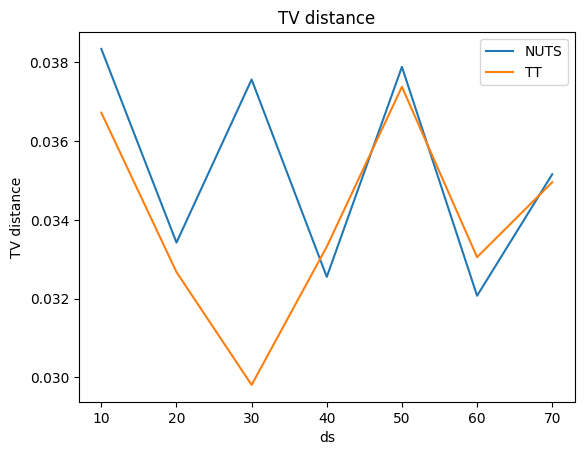

In [59]:
plt.plot(ds, nuts_tv, label='NUTS')
plt.plot(ds, tt_tv, label='TT')
plt.legend()
plt.title("TV distance")
plt.xlabel("ds")
plt.ylabel("TV distance")
plt.show()

In [60]:
from tensors.MALA import mala
malas = [0] * 8


In [130]:
a = 5.0
b = 0.02
k = 6
x, accs = mala(anses[k], log_grad_banana(a, b), banana(a, b), 0.4, k=10)

In [131]:
accs, x.shape

([0.61, 0.552, 0.586, 0.581, 0.603, 0.608, 0.556, 0.586, 0.571, 0.57],
 (1000, 70))

In [132]:
malas[k] = x

In [133]:
metrics = compute_metrics(
                    trues[k],
                    malas[k].reshape(1000, 1, -1),
                    name="MALA TT",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(2000, 70)
(1000, 1, 70)


  0%|          | 0/25 [00:00<?, ?it/s]

====MALA TT====
TV distance. Mean: 0.034, Std: 0.010. 
ESS: 0.481 
EMD: 964.909


In [134]:
#malas

In [135]:
mala_tv = []
for i in range(len(ds)):
    metrics_mala = compute_metrics(
                    trues[i],
                    malas[i].reshape(1000, 1, ds[i]),
                    name="TT",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
    )
   
    mala_tv.append(metrics_mala['tv_mean'].item())

(2000, 10)
(1000, 1, 10)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.036, Std: 0.012. 
ESS: 0.460 
EMD: 27.715
(2000, 20)
(1000, 1, 20)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.033, Std: 0.006. 
ESS: 0.525 
EMD: 123.752
(2000, 30)
(1000, 1, 30)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.028, Std: 0.009. 
ESS: 0.467 
EMD: 258.117
(2000, 40)
(1000, 1, 40)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.033, Std: 0.010. 
ESS: 0.474 
EMD: 417.778
(2000, 50)
(1000, 1, 50)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.033, Std: 0.006. 
ESS: 0.484 
EMD: 597.910
(2000, 60)
(1000, 1, 60)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.035, Std: 0.009. 
ESS: 0.497 
EMD: 777.338
(2000, 70)
(1000, 1, 70)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.034, Std: 0.010. 
ESS: 0.481 
EMD: 964.909


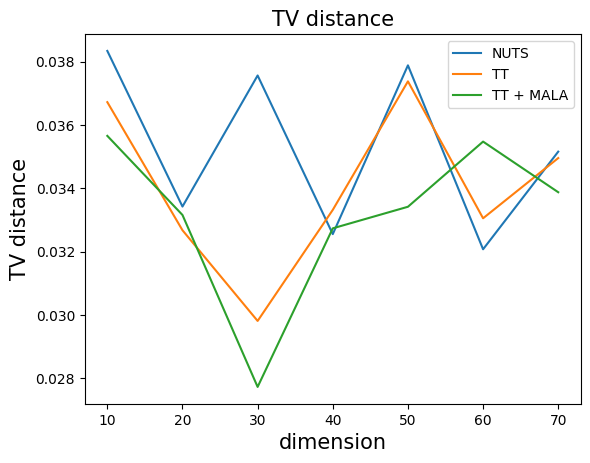

In [139]:
plt.plot(ds, nuts_tv, label='NUTS')
plt.plot(ds, tt_tv, label='TT')
plt.plot(ds, mala_tv, label='TT + MALA')

plt.legend()
plt.title("TV distance", fontdict={'fontsize':15})
plt.xlabel("dimension", fontdict={'fontsize':15})
plt.ylabel("TV distance", fontdict={'fontsize':15})
plt.show()

In [387]:
def sample_nuts_samples(target, proposal, samples, device = 'cpu', num_samples=1,
                        burn_in=2, rand_seed = 42):
    def true_target_energy(z):
        return -target(z)

    def energy(z):
        z = z["points"]
        return true_target_energy(z).sum()
    start_time = time.time()
    # kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
    kernel_true = NUTS(potential_fn=energy, full_mass=False)
    #kernel_true = HMC(potential_fn=energy, full_mass=False)
    pyro.set_rng_seed(rand_seed)
    init_samples = torch.tensor(samples, device=device)
    print(init_samples.shape) 
    #init_samples = torch.zeros_like(init_samples)
    dim = init_samples.shape[-1]
    init_params = {"points": init_samples}
    mcmc_true = MCMC(
        kernel=kernel_true,
        num_samples=num_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()
    q_true = mcmc_true.get_samples(group_by_chain=True)["points"].cpu()
    samples_true = np.array(q_true.view(-1, batch_size, dim))
    end_time = time.time()
    return end_time-start_time, samples_true

In [392]:
k=3
dim=ds[k]
sigma = 5.0
b = 0.02
target = Banana(
                dim=dim,
                device=device,
                b = b,
                sigma = sigma,
                #b = b
                #**dist_params.dict,
)
loc_proposal = torch.zeros(dim).to(device)
scale_proposal = 1.
scale_proposal = scale_proposal * torch.ones(dim).to(device)

proposal = IndependentNormal(
    dim=dim,
    loc=loc_proposal,
    scale=scale_proposal,
    device=device,
)

In [393]:
w = sample_nuts_samples(
                target,
                proposal,
                samples=malas[k]
)

torch.Size([1000, 40])


Sample: 100%|██████| 3/3 [00:00, 27.04it/s, step size=1.67e+00, acc. prob=0.000]


In [394]:
w[1].shape

(1000, 1, 40)

In [395]:
metrics = compute_metrics(
                    trues[k],
                    w[1],
                    name="MALA TT",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(2000, 40)
(1000, 1, 40)


  0%|          | 0/25 [00:00<?, ?it/s]

====MALA TT====
TV distance. Mean: 0.033, Std: 0.009. 
ESS: 0.485 
EMD: 427.952
